In [ ]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq langchain-groq==0.1.9 --progress-bar off
!pip install -qqq langgraph==0.2.14 --progress-bar off
!pip install -qqq openbb==4.3.1 --progress-bar off
!pip install -qqq duckduckgo-search==6.2.11 --progress-bar off
!pip install -qqq pandas_ta==0.3.14b --progress-bar off

  Preparing metadata (setup.py) ... done


In [ ]:
import sqlite3
import textwrap
from enum import Enum, auto
from typing import Annotated, List, Literal, TypedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
from duckduckgo_search import DDGS
from google.colab import userdata
from IPython.display import Image, display
from langchain_core.messages import HumanMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
from langgraph.graph import END, StateGraph
from openbb import obb

# MODEL = "llama3-groq-70b-8192-tool-use-preview"
MODEL = "llama-3.1-70b-versatile"
DB_NAME = "crypto_gpt.db"

llm = ChatGroq(temperature=0, model_name=MODEL, api_key=userdata.get("GROQ_API_KEY"))
obb.account.login(pat=userdata.get("OPENBB_API_KEY"))
obb.user.preferences.output_type = "dataframe"

Extensions to add: yfinance@1.3.2
Extensions to remove: yfinance@1.3.1

Building...


## Save Data

In [ ]:
def get_connection():
    return sqlite3.connect(DB_NAME)


db_connection = get_connection()

In [ ]:
money_df = obb.economy.money_measures(start_date="2010-01-01")
money_df.month = pd.to_datetime(money_df.month)
money_df.head()

/usr/local/lib/python3.10/dist-packages/openbb_federal_reserve/models/money_measures.py:92: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: float(x) if x != "-" and x is not None else x)


,month,M1,M2,currency,demand_deposits,retail_money_market_funds,small_denomination_time_deposits,other_liquid_deposits
0,2010-01-01,1674.2,8464.4,860.6,436.0,796.9,1163.6,NaN
1,2010-02-01,1685.2,8508.4,869.8,438.4,787.3,1142.3,NaN
2,2010-03-01,1729.5,8576.6,875.7,458.8,770.7,1119.7,NaN
3,2010-04-01,1716.0,8601.8,879.4,453.4,747.3,1097.8,NaN
4,2010-05-01,1708.2,8584.2,882.5,450.5,736.4,1075.0,NaN


In [ ]:
money_df = money_df[["month", "M1", "M2"]]
money_df.columns = ["date", "m1", "m2"]
money_df.head()

,date,m1,m2
0,2010-01-01,1674.2,8464.4
1,2010-02-01,1685.2,8508.4
2,2010-03-01,1729.5,8576.6
3,2010-04-01,1716.0,8601.8
4,2010-05-01,1708.2,8584.2


In [ ]:
money_df.to_sql("money_supply", db_connection)

175

In [ ]:
btc_df = obb.crypto.price.historical(symbol="BTCUSD", start_date="2010-01-01")
eth_df = obb.crypto.price.historical(symbol="ETHUSD", start_date="2010-01-01")
sol_df = obb.crypto.price.historical(symbol="SOLUSD", start_date="2010-01-01")

In [ ]:
btc_df.head()

,open,high,low,close,volume
date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0


In [ ]:
btc_df["date"] = pd.to_datetime(btc_df.index)
btc_df["ticker"] = "BTC"

eth_df["date"] = pd.to_datetime(eth_df.index)
eth_df["ticker"] = "ETH"

sol_df["date"] = pd.to_datetime(sol_df.index)
sol_df["ticker"] = "SOL"

In [ ]:
price_df = pd.concat([btc_df, eth_df, sol_df], axis=0).reset_index(drop=True)
price_df.head()

,open,high,low,close,volume,date,ticker
0,465.864014,468.174011,452.421997,457.334015,21056800.0,2014-09-17,BTC
1,456.859985,456.859985,413.104004,424.440002,34483200.0,2014-09-18,BTC
2,424.102997,427.834991,384.532013,394.795990,37919700.0,2014-09-19,BTC
3,394.673004,423.295990,389.882996,408.903992,36863600.0,2014-09-20,BTC
4,408.084991,412.425995,393.181000,398.821014,26580100.0,2014-09-21,BTC


In [ ]:
price_df = price_df[["date", "ticker", "open", "high", "low", "close", "volume"]]
price_df = price_df.sort_values(by="date").reset_index(drop=True)
price_df.tail()

,date,ticker,open,high,low,close,volume
7719,2024-08-28,BTC,59507.925781,60236.449219,57890.675781,59027.625000,4.028956e+10
7720,2024-08-28,SOL,146.897095,148.694977,140.970810,143.891388,2.932401e+09
7721,2024-08-29,BTC,59030.644531,61128.074219,58949.605469,60895.632812,3.446268e+10
7722,2024-08-29,ETH,2528.373779,2595.321045,2519.635986,2581.214600,1.592617e+10
7723,2024-08-29,SOL,143.901199,147.219055,143.244583,146.600296,2.270920e+09


In [ ]:
price_df.to_sql("prices", db_connection)

7724

In [ ]:
def search(keyword: str, max_results=100) -> pd.DataFrame:
    search_tool = DDGS()
    results = search_tool.news(
        keywords=keyword, safesearch="off", timelimit="m", max_results=max_results
    )
    df = pd.DataFrame.from_records(results)
    df["date"] = pd.to_datetime(df.date)
    return df.sort_values(by="date", ascending=False)

In [ ]:
crypto_news_df = search(keyword="Cryptocurrency")
btc_news_df = search(keyword="Bitcoin")
eth_news_df = search(keyword="Ethereum")
sol_news_df = search(keyword="Solana")
crypto_news_df.shape, btc_news_df.shape, eth_news_df.shape, sol_news_df.shape

((100, 6), (100, 6), (100, 6), (100, 6))

In [ ]:
crypto_news_df["ticker"] = None
btc_news_df["ticker"] = "BTC"
eth_news_df["ticker"] = "ETH"
sol_news_df["ticker"] = "SOL"

In [ ]:
news_df = pd.concat([crypto_news_df, btc_news_df, eth_news_df, sol_news_df], axis=0)
news_df = news_df.sort_values(by="date").reset_index(drop=True)
news_df.head()

,date,title,body,url,image,source,ticker
0,2024-07-30 18:07:00+00:00,How to invest in cryptocurrency? Here's a begi...,"Cryptocurrency, previously on the fringes, is ...",https://www.moneycontrol.com/news/business/how...,,moneycontrol.com,None
1,2024-07-31 08:12:00+00:00,Donald Trump's Plan to Hoard Billions in Bitco...,The former US president has promised to establ...,https://www.wired.com/story/donald-trumps-plan...,,Wired,BTC
2,2024-07-31 08:58:00+00:00,Ethereum price today: ETH is up 39% year to date,The return comparisons are as of 8 a.m. ET. Al...,https://www.usatoday.com/money/blueprint/inves...,,USA Today,ETH
3,2024-07-31 14:00:00+00:00,"Is Bitcoin Inevitable? If So, Does Anyone Need...",One of the deeply philosophical and contentiou...,https://www.forbes.com/sites/digital-assets/20...,,Forbes,BTC
4,2024-08-01 00:00:00+00:00,Bitcoin Goes All In With Trump,With 10 senators and Trump in attendance at th...,https://www.thenation.com/article/politics/bit...,,The Nation,BTC


In [ ]:
news_df.to_sql("news", db_connection)

400

## Historical Prices

In [ ]:
class Ticker(Enum):
    BTC = auto()
    ETH = auto()
    SOL = auto()


class TimeFrame(Enum):
    DAILY = auto()
    WEEKLY = auto()
    MONTHLY = auto()


def get_price_data(
    ticker: Ticker, time_frame: TimeFrame = TimeFrame.DAILY
) -> pd.DataFrame:
    query = """
    SELECT date, high, low, close, volume
    FROM prices
    WHERE ticker=?
    ORDER BY date"""
    with get_connection() as connection:
        df = pd.read_sql(
            query,
            connection,
            params=[ticker.name],
            index_col="date",
            parse_dates=["date"],
        )
        if time_frame == TimeFrame.DAILY:
            return df
        interval = "W" if time_frame == TimeFrame.WEEKLY else "M"
        return df.resample(interval).agg(
            {"high": "max", "low": "min", "close": "last", "volume": "sum"}
        )


def get_money_supply() -> pd.DataFrame:
    query = """
    SELECT date, m1, m2
    FROM money_supply
    ORDER BY date
    """
    with get_connection() as connection:
        return pd.read_sql(query, connection, index_col="date", parse_dates=["date"])

In [ ]:
money_supply_df = get_money_supply()
money_supply_df.head()

,m1,m2
date,,
2010-01-01,1674.2,8464.4
2010-02-01,1685.2,8508.4
2010-03-01,1729.5,8576.6
2010-04-01,1716.0,8601.8
2010-05-01,1708.2,8584.2


In [ ]:
eth_weekly_df = get_price_data(Ticker.ETH, time_frame=TimeFrame.WEEKLY)
eth_weekly_df.head()

,high,low,close,volume
date,,,,
2017-11-12,329.451996,294.541992,307.907990,4.235017e+09
2017-11-19,371.290985,307.024994,354.385986,6.084392e+09
2017-11-26,485.191986,350.692993,471.329987,9.316128e+09
2017-12-03,522.307007,401.243011,465.852997,1.050405e+10
2017-12-10,504.147003,414.411011,441.721008,1.209451e+10


### Indicators

In [ ]:
def add_indicators(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy()
    macd_df = ta.macd(data["close"])
    bbands_df = ta.bbands(data["close"])

    data["ma_50"] = data["close"].rolling(50).mean()
    data["ma_200"] = data["close"].rolling(200).mean()
    data["rsi"] = ta.rsi(data["close"])
    data["macd"], data["macd_signal"], data["macd_histogram"] = (
        macd_df.iloc[:, 0],
        macd_df.iloc[:, 1],
        macd_df.iloc[:, 2],
    )
    data["bb_lower"], data["bb_middle"], data["bb_upper"] = (
        bbands_df.iloc[:, 0],
        bbands_df.iloc[:, 1],
        bbands_df.iloc[:, 2],
    )
    return data

In [ ]:
add_indicators(eth_weekly_df).tail()

,high,low,close,volume,ma_50,ma_200,rsi,macd,macd_signal,macd_histogram,bb_lower,bb_middle,bb_upper
date,,,,,,,,,,,,,
2024-08-04,3396.625732,2639.566650,2686.398926,1.291176e+11,2674.547463,2236.663028,42.933270,106.353238,-104.377164,210.730402,2543.456667,3133.587061,3723.717454
2024-08-11,2721.954590,2122.546143,2553.252197,1.823062e+11,2692.462246,2247.553579,41.169057,43.290933,-133.951575,177.242508,2308.900084,3058.360059,3807.820033
2024-08-18,2775.281006,2513.394043,2613.357178,9.936671e+10,2712.007036,2258.729296,42.321282,-1.815501,-143.246407,141.430906,2139.202792,2932.215674,3725.228556
2024-08-25,2820.020508,2538.657715,2749.157715,8.670627e+10,2734.653613,2270.443996,44.944923,-26.301518,-134.185939,107.884421,2260.687068,2774.726123,3288.765178
2024-09-01,2763.004150,2401.175049,2581.214600,6.659675e+10,2753.819971,2281.368278,42.377655,-58.583159,-133.174064,74.590905,2493.278018,2636.676123,2780.074228


In [ ]:
def calculate_50_percent(data: pd.DataFrame, n_weeks: int = 4):
    last_n_weeks = data.tail(n=n_weeks)
    low = last_n_weeks.low.min()
    high = last_n_weeks.high.max()
    return (low + high) / 2, low, high

## News

In [ ]:
def get_news_data(ticker: Ticker, max_articles_per_day: int = 5) -> pd.DataFrame:
    query = """
    SELECT date, title, body
    FROM news
    WHERE ticker=? OR ticker IS NULL
    ORDER BY date
    """
    with get_connection() as connection:
        df = pd.read_sql(
            query,
            connection,
            params=[ticker.name],
            index_col="date",
            parse_dates=["date"],
        )
        groups = [
            group.sample(min(len(group), max_articles_per_day))
            for _, group in df.groupby(df.index.date)
        ]
        return pd.concat(groups)

In [ ]:
btc_news_df = get_news_data(Ticker.BTC)
btc_news_df.shape

(76, 2)

In [ ]:
btc_news_df.head()

,title,body
date,,
2024-07-30 18:07:00+00:00,How to invest in cryptocurrency? Here's a begi...,"Cryptocurrency, previously on the fringes, is ..."
2024-07-31 14:00:00+00:00,"Is Bitcoin Inevitable? If So, Does Anyone Need...",One of the deeply philosophical and contentiou...
2024-07-31 08:12:00+00:00,Donald Trump's Plan to Hoard Billions in Bitco...,The former US president has promised to establ...
2024-08-01 02:01:00+00:00,"No, Bitcoin Won't Solve Our National Debt","At a Bitcoin conference last weekend, Senator ..."
2024-08-01 20:58:00+00:00,FBI Issues New Warning If You Buy Crypto From ...,With the billions of dollars held by cryptocur...


## Graph

### State

In [ ]:
class TickerQuery(BaseModel):
    """Ticker symbol requested by the user"""

    ticker: Literal["BTC", "ETH", "SOL"] = Field(
        description="Ticker symbol for the chosen cryptocurrency",
    )


class FinalReport(BaseModel):
    """Report created by the financial reporter"""

    action: Literal["BUY", "HODL", "SELL"] = Field(
        description="Action to take with the chosen cryptocurrency"
    )
    score: int = Field(
        description="Bullishness market score between 0 (extremely bearish) and 100 (extremely bullish)"
    )
    trend: Literal["UP", "NEUTRAL", "DOWN"] = Field(
        description="Price trend for the chosen cryptocurrency",
    )
    sentiment: Literal["GREED", "NEUTRAL", "FEAR"] = Field(
        description="Sentiment from the news for the chosen cryptocurrency"
    )
    price_predictions: List[float] = Field(
        description="Price predictions for 1, 2, 3 and 4 weeks ahead"
    )
    summary: str = Field(
        description="Summary of the current market conditions (1-3 sentences)"
    )


class AppState(TypedDict):
    user_query: str
    ticker: Ticker
    news: pd.DataFrame
    prices: pd.DataFrame
    price_analyst_report: str
    news_analyst_report: str
    final_report: FinalReport

### Nodes

In [ ]:
def ticker_extractor(state: AppState):
    ticker_extractor_llm = llm.with_structured_output(TickerQuery)
    extraction = ticker_extractor_llm.invoke([HumanMessage(state["user_query"])])
    return {"ticker": Ticker[extraction.ticker]}

In [ ]:
def news_retriever(state: AppState):
    ticker = state["ticker"]
    ticker_to_keyword = {
        Ticker.BTC: "Bitcoin",
        Ticker.ETH: "Ethereum",
        Ticker.SOL: "Solana",
    }
    news_df = search(ticker_to_keyword[ticker])
    return {"news": news_df}

In [ ]:
def price_retriever(state: AppState):
    ticker = state["ticker"]
    price_df = get_price_data(ticker, time_frame=TimeFrame.WEEKLY)
    price_df = add_indicators(price_df)
    price_df = price_df.tail(n=24)
    return {"prices": price_df}

In [ ]:
def price_analyst(state: AppState):

    price_df = state["prices"]
    weeks_4_50_percent, _, _ = calculate_50_percent(price_df, n_weeks=4)
    weeks_12_50_percent, _, _ = calculate_50_percent(price_df, n_weeks=12)
    weeks_26_50_percent, _, _ = calculate_50_percent(price_df, n_weeks=26)

    money_supply_df = get_money_supply()
    money_supply_text = str(money_supply_df["m2"])

    prompt = f"""You have extensive knowledge of the cryptocurrency market and historical data.
Think step-by-step and focus on the technical indicators.
Use the following weekly close price history and technical indicators for ETH:

price history:
```
{str(price_df[price_df.columns[2:]])}
```

M2 money supply history:
```
{money_supply_text}
```

4 weeks 50% level: {weeks_4_50_percent}
12 weeks 50% level: {weeks_12_50_percent}
26 weeks 50% level: {weeks_26_50_percent}

Predict the next 4 weekly prices based on the data. Put the predictions on separate line.
How certain are you of your predictions? Use a number between 0 (not certain at all) to 10 (sure thing).
What is the overall trend outlook? Explain your predictions in 1-3 sentences.

When creating your answer, focus on answering the user query:
{state["user_query"]}
"""
    response = llm.invoke([HumanMessage(prompt)])
    return {"price_analyst_report": response.content}

In [ ]:
def news_analyst(state: AppState):
    news_df = state["news"]
    news_text = ""
    for _, row in list(news_df.iterrows())[:20]:
        news_text += f"{row.date}\n{row.title}\n{row.body}\n---\n"

    prompt = f"""Choose a combined sentiment that best represents these news articles:

```
{news_text}
```

Each article is separated by `---`.

Pick a number for the sentiment between 0 and 100 where:

- 0 is extremely bearish
- 100 is extremely bullish

Reply only with the sentiment and a short explanation (1-2 sentences) of why.

When creating your answer, focus on answering the user query:
{state["user_query"]}
"""
    response = llm.invoke([HumanMessage(prompt)])
    return {"news_analyst_report": response.content}

In [ ]:
def financial_reporter(state: AppState):
    price_report = state["price_analyst_report"]
    news_report = state["news_analyst_report"]
    prompt = f"""You're a senior cryptocurrency expert that makes extremely accurate predictions
about future prices and trend in the crypto market. You're well versed into technological advancements
and tokenomics of various projects.

You're working with two other agents that have created reports of the current state of the crypto market.

Report of the news analyst:

```
{news_report}
```

Report of the price analyst:

```
{price_report}
```

Based on the provided information, create a final report for the user.

When creating your answer, focus on answering the user query:
{state["user_query"]}
"""
    final_report_llm = llm.with_structured_output(FinalReport)
    response = final_report_llm.invoke([HumanMessage(prompt)])
    return {"final_report": response}

### Building the Graph

In [ ]:
graph = StateGraph(AppState)

In [ ]:
graph.add_node("ticker_extractor", ticker_extractor)
graph.add_node("news_retriever", news_retriever)
graph.add_node("price_retriever", price_retriever)
graph.add_node("price_analyst", price_analyst)
graph.add_node("news_analyst", news_analyst)
graph.add_node("financial_reporter", financial_reporter)

In [ ]:
graph.add_edge("ticker_extractor", "price_retriever")
graph.add_edge("ticker_extractor", "news_retriever")
graph.add_edge("news_retriever", "news_analyst")
graph.add_edge("price_retriever", "price_analyst")
graph.add_edge("price_analyst", "financial_reporter")
graph.add_edge("news_analyst", "financial_reporter")

graph.set_entry_point("ticker_extractor")
graph.set_finish_point("financial_reporter")

In [ ]:
app = graph.compile()

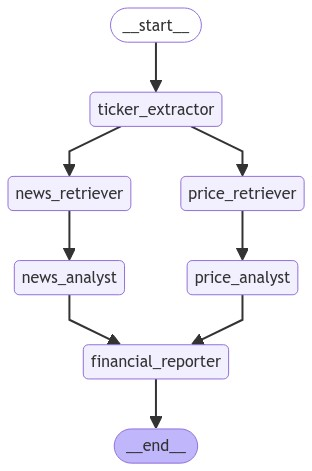

In [ ]:
display(Image(app.get_graph().draw_mermaid_png()))

## Run the Graph

In [ ]:
config = {"configurable": {"thread_id": 42}}

state = app.invoke(
    {"user_query": "Analyze the long-term potential of Ethereum"},
    config=config,
)

In [ ]:
print(state.keys())

dict_keys(['user_query', 'ticker', 'news', 'prices', 'price_analyst_report', 'news_analyst_report', 'final_report'])


In [ ]:
for line in state["price_analyst_report"].split("\n"):
    print(textwrap.fill(line, 80))

**Predictions:**

1. 2024-09-08: 2700
2. 2024-09-15: 2750
3. 2024-09-22: 2800
4. 2024-09-29: 2850

**Certainty:** 6

**Overall Trend Outlook:** The overall trend outlook for Ethereum is bullish in
the long term, driven by the increasing adoption of decentralized finance (DeFi)
and non-fungible tokens (NFTs). However, in the short term, Ethereum's price may
experience some volatility due to the current bearish sentiment in the
cryptocurrency market.

**Analysis:**

The provided data shows that Ethereum's price has been trending downwards since
June 2024, with a significant drop in August 2024. However, the Relative
Strength Index (RSI) has been oversold since July 2024, indicating a potential
reversal in the trend.

The Moving Average Convergence Divergence (MACD) indicator has been bearish
since June 2024, but the histogram has been narrowing, indicating a potential
crossover. The Bollinger Bands have been tightening, indicating a potential
breakout.

The M2 money supply history shows 

In [ ]:
for line in state["news_analyst_report"].split("\n"):
    print(textwrap.fill(line, 80))

Sentiment: 62

The overall sentiment is slightly bullish due to the presence of positive news
such as BlackRock listing an Ethereum ETF in Brazil, Ethereum's price recovery,
and predictions of a potential 85% rally. However, bearish sentiments from some
analysts and concerns about Ethereum's growth and competition from other
cryptocurrencies, such as Solana, temper the overall optimism.


In [ ]:
report = state["final_report"]

print(
    f"""
Action:     {report.action}
Score:      {report.score}
Trend:      {report.trend}
Sentiment:  {report.sentiment}

Price predictions (4 weeks ahead):
{report.price_predictions}

Summary:
{textwrap.fill(report.summary, 80)}
"""
)


Action:     HODL
Score:      62
Trend:      UP
Sentiment:  NEUTRAL

Price predictions (4 weeks ahead): 
[2700.0, 2750.0, 2800.0, 2850.0]
      
Summary:
Ethereum's long-term potential is bullish, driven by increasing adoption of DeFi
and NFTs, with potential short-term volatility due to bearish sentiment in the
cryptocurrency market.

